# DS57 Relative Location and Dispersion Analysis
This notebook computes quartiles, percentiles, and dispersion statistics for cleaned GRDP datasets, then saves required tables and visualizations.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Robust BASE_DIR resolution for notebook and script contexts.
try:
    BASE_DIR = Path(__file__).resolve().parents[2]
except NameError:
    cwd = Path.cwd().resolve()
    if (cwd / "03_Cleaned_Data").exists():
        BASE_DIR = cwd
    elif (cwd.parent / "03_Cleaned_Data").exists():
        BASE_DIR = cwd.parent
    elif len(cwd.parents) > 1 and (cwd.parents[1] / "03_Cleaned_Data").exists():
        BASE_DIR = cwd.parents[1]
    else:
        BASE_DIR = cwd.parents[1] if len(cwd.parents) > 1 else cwd

CLEAN_DIR = BASE_DIR / "03_Cleaned_Data"
OUT_TABLES = BASE_DIR / "outputs" / "tables"
OUT_FIGS = BASE_DIR / "outputs" / "figures"

OUT_TABLES.mkdir(parents=True, exist_ok=True)
OUT_FIGS.mkdir(parents=True, exist_ok=True)

print(f"BASE_DIR: {BASE_DIR}")
print(f"CLEAN_DIR exists: {CLEAN_DIR.exists()}")
print(f"OUT_TABLES: {OUT_TABLES}")
print(f"OUT_FIGS: {OUT_FIGS}")


BASE_DIR: C:\Users\Anthony Llena\OneDrive\Documents\SLU\DATA SCI PRELIMS\9345-Prelim-Summative-Activity-TeamWPS
CLEAN_DIR exists: True
OUT_TABLES: C:\Users\Anthony Llena\OneDrive\Documents\SLU\DATA SCI PRELIMS\9345-Prelim-Summative-Activity-TeamWPS\outputs\tables
OUT_FIGS: C:\Users\Anthony Llena\OneDrive\Documents\SLU\DATA SCI PRELIMS\9345-Prelim-Summative-Activity-TeamWPS\outputs\figures


In [2]:
# Load cleaned datasets
file_d1 = CLEAN_DIR / "Dataset 1 Regional_Economic_Magnitude (CLEANED).csv"
file_d2 = CLEAN_DIR / "Dataset 2 Sector_Economic_Structure (CLEANED).csv"
file_d3 = CLEAN_DIR / "Dataset 3 Region_Sector_Structure (CLEANED).csv"

df1 = pd.read_csv(file_d1)
df2 = pd.read_csv(file_d2)
df3 = pd.read_csv(file_d3)

print("Dataset 1 shape:", df1.shape)
print(df1.head())
print("\nDataset 2 shape:", df2.shape)
print(df2.head())
print("\nDataset 3 shape:", df3.shape)
print(df3.head())


Dataset 1 shape: (810, 4)
                                            Region  Year  \
0  Bangsamoro Autonomous Region in Muslim Mindanao  2000   
1  Bangsamoro Autonomous Region in Muslim Mindanao  2000   
2  Bangsamoro Autonomous Region in Muslim Mindanao  2001   
3  Bangsamoro Autonomous Region in Muslim Mindanao  2001   
4  Bangsamoro Autonomous Region in Muslim Mindanao  2002   

                Price_Type   Total_GRDP  
0  At Constant 2018 Prices   98017851.0  
1        At Current Prices   45671649.0  
2  At Constant 2018 Prices   94136902.0  
3        At Current Prices   44751362.0  
4  At Constant 2018 Prices  105745055.0  

Dataset 2 shape: (150, 4)
                          Main_Sector  Year               Price_Type  \
0  Agriculture, forestry, and fishing  2000  At Constant 2018 Prices   
1  Agriculture, forestry, and fishing  2000        At Current Prices   
2  Agriculture, forestry, and fishing  2001  At Constant 2018 Prices   
3  Agriculture, forestry, and fishing  2001   

In [3]:
def summarize_relative_location(df, value_col, group_cols, label):
    # Compute relative location and dispersion statistics by group.
    records = []

    for group_key, grp in df.groupby(group_cols, dropna=False):
        values = pd.to_numeric(grp[value_col], errors="coerce").dropna().to_numpy()
        n = values.size

        if n == 0:
            mean = median = std = var = vmin = vmax = np.nan
            q1 = q3 = iqr = p10 = p25 = p50 = p75 = p90 = np.nan
            value_range = cv = qcd = np.nan
        else:
            mean = float(np.mean(values))
            median = float(np.median(values))
            std = float(np.std(values, ddof=1)) if n > 1 else np.nan
            var = float(np.var(values, ddof=1)) if n > 1 else np.nan
            vmin = float(np.min(values))
            vmax = float(np.max(values))

            p10, p25, p50, p75, p90 = np.percentile(values, [10, 25, 50, 75, 90])
            q1 = float(p25)
            q3 = float(p75)
            iqr = float(q3 - q1)
            value_range = float(vmax - vmin)

            cv = float(std / mean) if (pd.notna(std) and mean != 0) else np.nan
            denom = q3 + q1
            qcd = float((q3 - q1) / denom) if denom != 0 else np.nan

        if not isinstance(group_key, tuple):
            group_key = (group_key,)

        record = {col: val for col, val in zip(group_cols, group_key)}
        record.update({
            "n": int(n),
            "mean": mean,
            "median": median,
            "std": std,
            "var": var,
            "min": vmin,
            "max": vmax,
            "range": value_range,
            "Q1": q1,
            "Q3": q3,
            "IQR": iqr,
            "P10": float(p10) if n > 0 else np.nan,
            "P25": float(p25) if n > 0 else np.nan,
            "P50": float(p50) if n > 0 else np.nan,
            "P75": float(p75) if n > 0 else np.nan,
            "P90": float(p90) if n > 0 else np.nan,
            "CV": cv,
            "QCD": qcd,
        })
        records.append(record)

    out_cols = [
        *group_cols,
        "n", "mean", "median", "std", "var", "min", "max", "range",
        "Q1", "Q3", "IQR", "P10", "P25", "P50", "P75", "P90", "CV", "QCD"
    ]

    summary = pd.DataFrame(records)[out_cols].sort_values(group_cols).reset_index(drop=True)
    numeric_cols = [col for col in summary.columns if col not in group_cols]
    summary[numeric_cols] = summary[numeric_cols].round(4)

    print(f"{label}: {summary.shape[0]} rows")
    return summary


In [4]:
# Apply summaries to required groupings

d1_by_price = summarize_relative_location(
    df1, value_col="Total_GRDP", group_cols=["Price_Type"], label="Dataset 1 by Price_Type"
)

d1_by_region_price = summarize_relative_location(
    df1, value_col="Total_GRDP", group_cols=["Region", "Price_Type"], label="Dataset 1 by Region and Price_Type"
)

d2_by_sector_price = summarize_relative_location(
    df2, value_col="Total_GRDP", group_cols=["Main_Sector", "Price_Type"], label="Dataset 2 by Main_Sector and Price_Type"
)

d3_by_region_sector_price = summarize_relative_location(
    df3, value_col="Sector_GRDP", group_cols=["Region", "Main_Sector", "Price_Type"], label="Dataset 3 by Region, Main_Sector, Price_Type"
)

print("\nPreview: Dataset 1 by Price_Type")
print(d1_by_price.head())


Dataset 1 by Price_Type: 2 rows
Dataset 1 by Region and Price_Type: 36 rows
Dataset 2 by Main_Sector and Price_Type: 6 rows
Dataset 3 by Region, Main_Sector, Price_Type: 144 rows

Preview: Dataset 1 by Price_Type
                Price_Type    n          mean       median           std  \
0  At Constant 2018 Prices  405  9.079412e+08  411149258.0  1.407433e+09   
1        At Current Prices  405  8.559355e+08  381711706.0  1.493068e+09   

            var         min           max         range           Q1  \
0  1.980868e+18  94136902.0  1.314890e+10  1.305476e+10  260522888.0   
1  2.229251e+18  44751362.0  1.514522e+10  1.510047e+10  194874139.0   

            Q3          IQR          P10          P25          P50  \
0  882189256.0  621666368.0  176543077.6  260522888.0  411149258.0   
1  854442889.0  659568750.0  115195908.6  194874139.0  381711706.0   

           P75           P90      CV     QCD  
0  882189256.0  2.135225e+09  1.5501  0.5440  
1  854442889.0  2.040165e+09  1.7444

In [5]:
# Save summary tables

d1_by_price.to_csv(OUT_TABLES / "DS57_dataset1_by_price_type.csv", index=False)
d1_by_region_price.to_csv(OUT_TABLES / "DS57_dataset1_by_region_price.csv", index=False)
d2_by_sector_price.to_csv(OUT_TABLES / "DS57_dataset2_by_sector_price.csv", index=False)
d3_by_region_sector_price.to_csv(OUT_TABLES / "DS57_dataset3_by_region_sector_price.csv", index=False)

checklist = pd.DataFrame([
    {
        "dataset": "Dataset 1 Regional_Economic_Magnitude",
        "grouping": "Price_Type",
        "stats_included": "Q1,Q3,IQR,P10,P90,CV,QCD",
        "rows": len(d1_by_price),
    },
    {
        "dataset": "Dataset 1 Regional_Economic_Magnitude",
        "grouping": "Region, Price_Type",
        "stats_included": "Q1,Q3,IQR,P10,P90,CV,QCD",
        "rows": len(d1_by_region_price),
    },
    {
        "dataset": "Dataset 2 Sector_Economic_Structure",
        "grouping": "Main_Sector, Price_Type",
        "stats_included": "Q1,Q3,IQR,P10,P90,CV,QCD",
        "rows": len(d2_by_sector_price),
    },
    {
        "dataset": "Dataset 3 Region_Sector_Structure",
        "grouping": "Region, Main_Sector, Price_Type",
        "stats_included": "Q1,Q3,IQR,P10,P90,CV,QCD",
        "rows": len(d3_by_region_sector_price),
    },
])

checklist.to_csv(OUT_TABLES / "DS57_compliance_checklist.csv", index=False)

print("Saved tables to:", OUT_TABLES)
print(checklist)


Saved tables to: C:\Users\Anthony Llena\OneDrive\Documents\SLU\DATA SCI PRELIMS\9345-Prelim-Summative-Activity-TeamWPS\outputs\tables
                                 dataset                         grouping  \
0  Dataset 1 Regional_Economic_Magnitude                       Price_Type   
1  Dataset 1 Regional_Economic_Magnitude               Region, Price_Type   
2    Dataset 2 Sector_Economic_Structure          Main_Sector, Price_Type   
3      Dataset 3 Region_Sector_Structure  Region, Main_Sector, Price_Type   

             stats_included  rows  
0  Q1,Q3,IQR,P10,P90,CV,QCD     2  
1  Q1,Q3,IQR,P10,P90,CV,QCD    36  
2  Q1,Q3,IQR,P10,P90,CV,QCD     6  
3  Q1,Q3,IQR,P10,P90,CV,QCD   144  


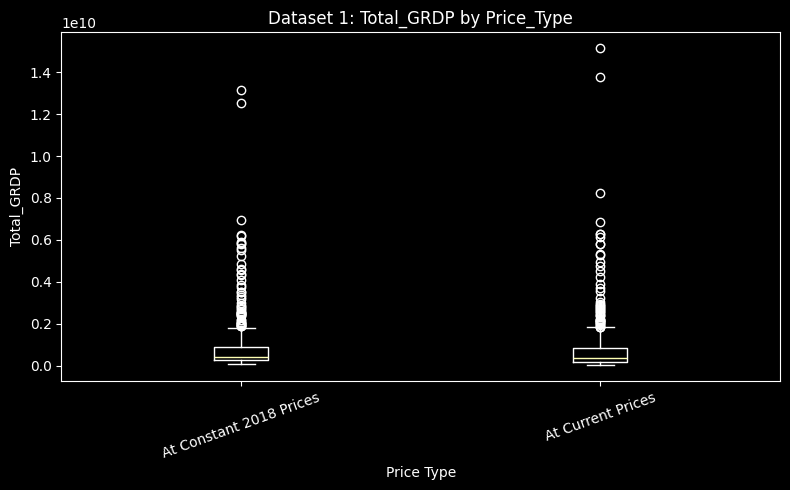

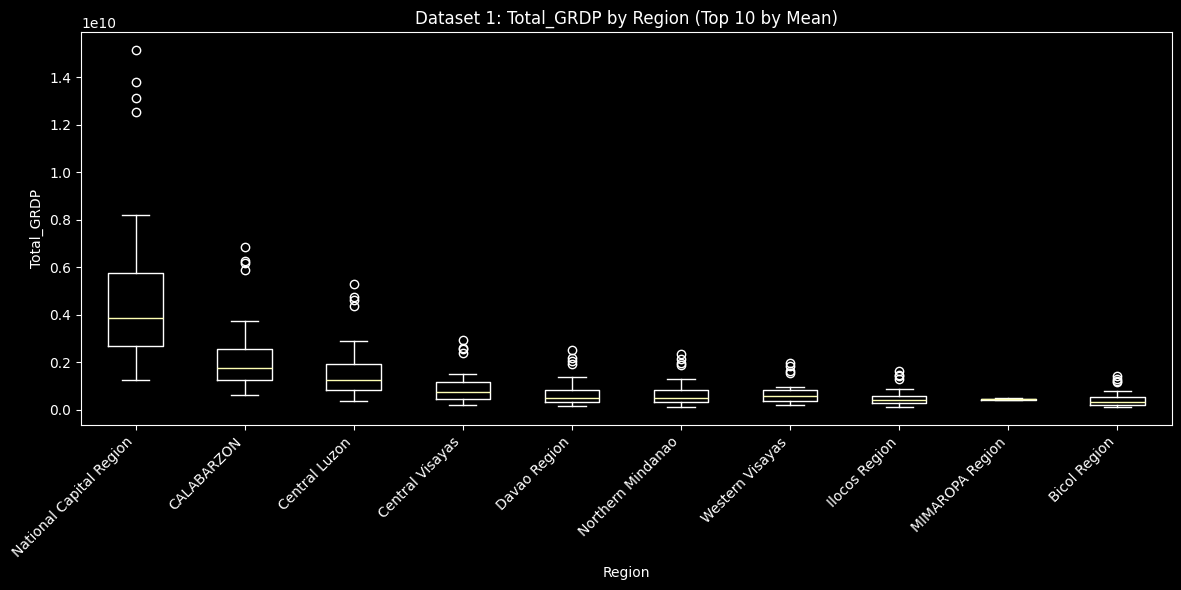

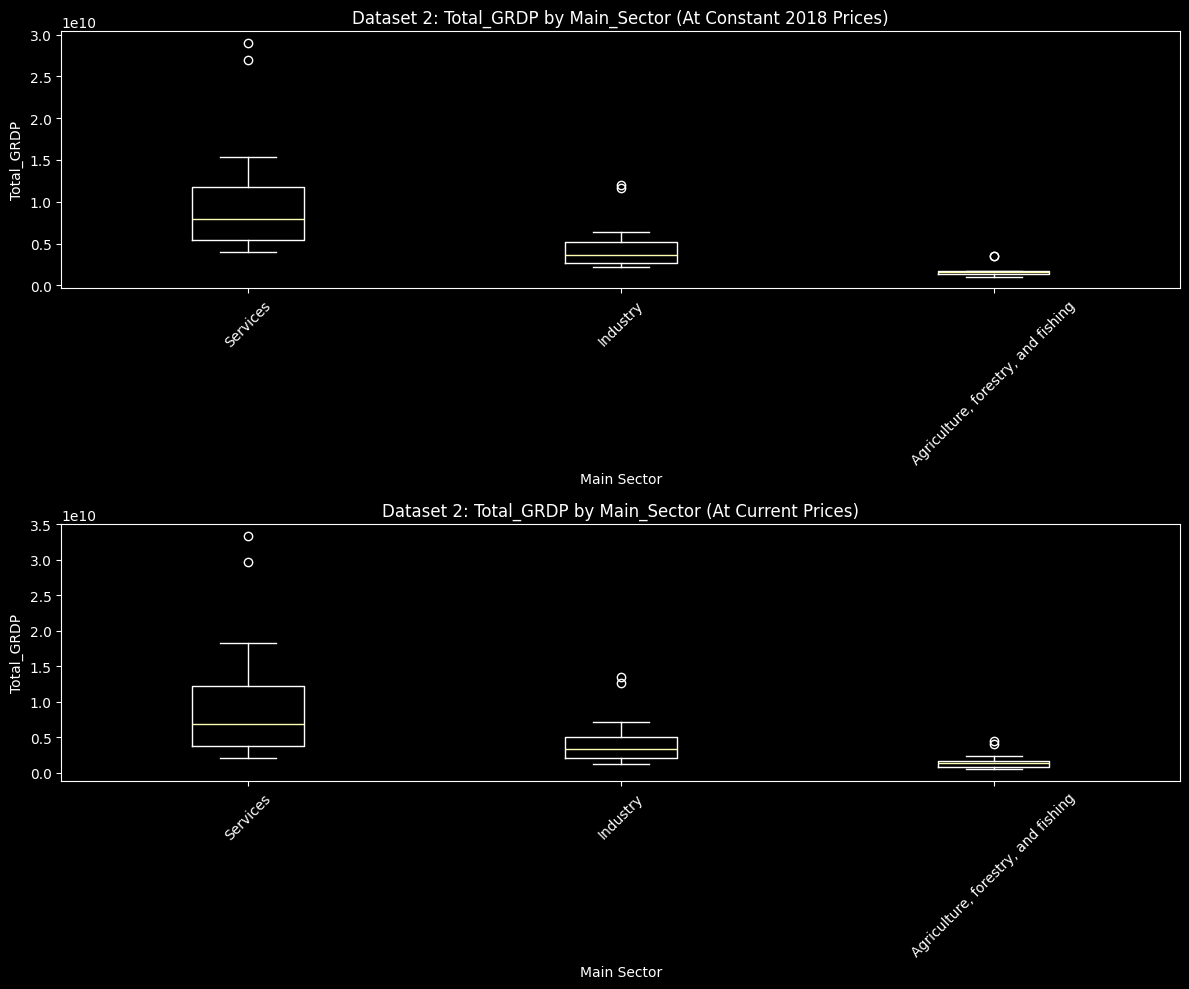

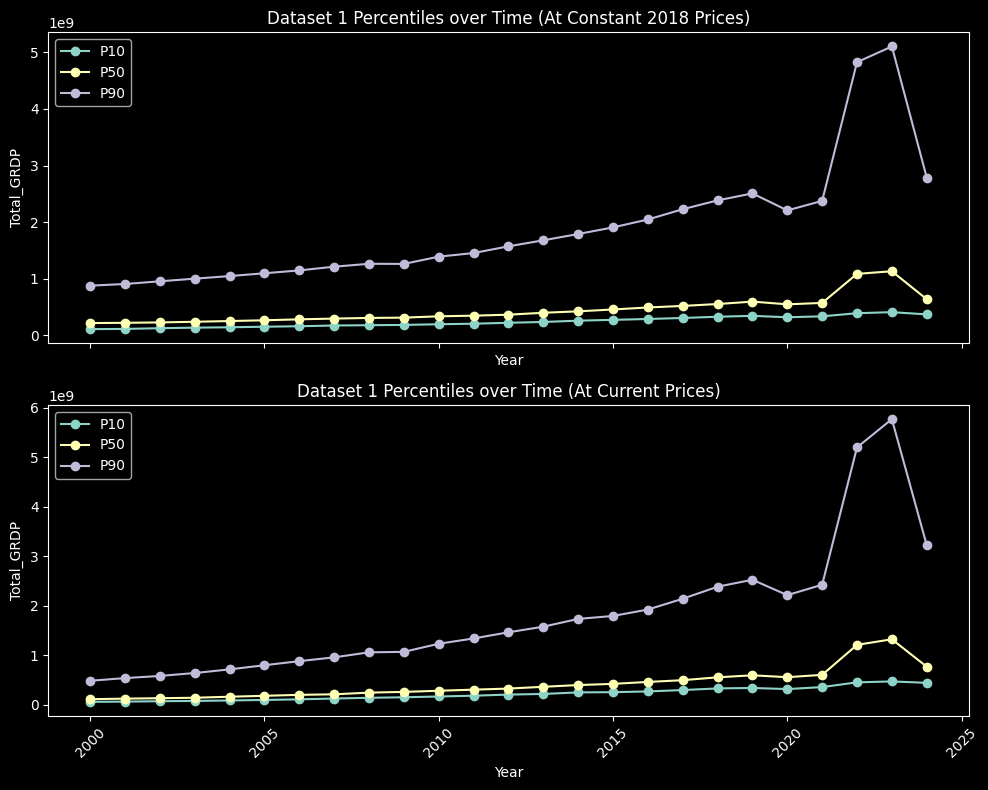

Saved figures to: C:\Users\Anthony Llena\OneDrive\Documents\SLU\DATA SCI PRELIMS\9345-Prelim-Summative-Activity-TeamWPS\outputs\figures


In [6]:
# Visualizations (matplotlib only)

# 1) Boxplot of Total_GRDP by Price_Type for Dataset 1
price_types = sorted(df1["Price_Type"].dropna().unique())
box_data_price = [
    pd.to_numeric(df1.loc[df1["Price_Type"] == pt, "Total_GRDP"], errors="coerce").dropna().values
    for pt in price_types
]

plt.figure(figsize=(8, 5))
plt.boxplot(box_data_price, tick_labels=price_types)
plt.title("Dataset 1: Total_GRDP by Price_Type")
plt.xlabel("Price Type")
plt.ylabel("Total_GRDP")
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(OUT_FIGS / "DS57_box_price_type.png", dpi=300)
plt.show()

# 2) Boxplot of Total_GRDP by top 10 Regions for Dataset 1
region_top10 = (
    df1.groupby("Region", dropna=False)["Total_GRDP"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

box_data_region = [
    pd.to_numeric(df1.loc[df1["Region"] == region, "Total_GRDP"], errors="coerce").dropna().values
    for region in region_top10
]

plt.figure(figsize=(12, 6))
plt.boxplot(box_data_region, tick_labels=region_top10)
plt.title("Dataset 1: Total_GRDP by Region (Top 10 by Mean)")
plt.xlabel("Region")
plt.ylabel("Total_GRDP")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(OUT_FIGS / "DS57_box_region_top10.png", dpi=300)
plt.show()

# 3) Boxplot of Total_GRDP by Main_Sector for Dataset 2 (subplot per Price_Type)
price_types_d2 = sorted(df2["Price_Type"].dropna().unique())
fig, axes = plt.subplots(len(price_types_d2), 1, figsize=(12, 5 * len(price_types_d2)))
if len(price_types_d2) == 1:
    axes = [axes]

for ax, pt in zip(axes, price_types_d2):
    sub = df2[df2["Price_Type"] == pt].copy()
    sector_order = (
        sub.groupby("Main_Sector", dropna=False)["Total_GRDP"]
        .mean()
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    box_data_sector = [
        pd.to_numeric(sub.loc[sub["Main_Sector"] == s, "Total_GRDP"], errors="coerce").dropna().values
        for s in sector_order
    ]

    ax.boxplot(box_data_sector, tick_labels=sector_order)
    ax.set_title(f"Dataset 2: Total_GRDP by Main_Sector ({pt})")
    ax.set_xlabel("Main Sector")
    ax.set_ylabel("Total_GRDP")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig(OUT_FIGS / "DS57_box_sector.png", dpi=300)
plt.show()

# 4) Optional line plot: P10/P50/P90 over Year for Dataset 1 by Price_Type
percentile_records = []
for (pt, year), grp in df1.groupby(["Price_Type", "Year"], dropna=False):
    vals = pd.to_numeric(grp["Total_GRDP"], errors="coerce").dropna().values
    if vals.size == 0:
        continue
    p10, p50, p90 = np.percentile(vals, [10, 50, 90])
    percentile_records.append({
        "Price_Type": pt,
        "Year": year,
        "P10": p10,
        "P50": p50,
        "P90": p90,
    })

pct_df = pd.DataFrame(percentile_records).sort_values(["Price_Type", "Year"])

if not pct_df.empty:
    price_types_pct = sorted(pct_df["Price_Type"].dropna().unique())
    fig, axes = plt.subplots(len(price_types_pct), 1, figsize=(10, 4 * len(price_types_pct)), sharex=True)
    if len(price_types_pct) == 1:
        axes = [axes]

    for ax, pt in zip(axes, price_types_pct):
        sub = pct_df[pct_df["Price_Type"] == pt].sort_values("Year")
        ax.plot(sub["Year"], sub["P10"], marker="o", label="P10")
        ax.plot(sub["Year"], sub["P50"], marker="o", label="P50")
        ax.plot(sub["Year"], sub["P90"], marker="o", label="P90")
        ax.set_title(f"Dataset 1 Percentiles over Time ({pt})")
        ax.set_xlabel("Year")
        ax.set_ylabel("Total_GRDP")
        ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(OUT_FIGS / "DS57_percentiles_over_time.png", dpi=300)
    plt.show()

print("Saved figures to:", OUT_FIGS)


In [9]:
import numpy as np

# -----------------------------
# Interpretation (short, clean)
# -----------------------------

def safe_numeric_series(s):
    """Replace inf with NaN and coerce numeric where possible."""
    s = s.replace([np.inf, -np.inf], np.nan)
    return pd.to_numeric(s, errors="coerce")


def top_group(summary_df, group_cols, metric, fmt="{:.4f}"):
    """
    Return the group with the highest metric value.
    Example output: "NCR, At Current Prices (CV=0.1234)"
    """
    if summary_df is None or summary_df.empty:
        return "N/A"

    if metric not in summary_df.columns:
        return "N/A"

    s = summary_df.copy()
    s[metric] = safe_numeric_series(s[metric])

    if s[metric].dropna().empty:
        return "N/A"

    idx = s[metric].idxmax()
    grp_label = ", ".join(str(s.loc[idx, col]) for col in group_cols)
    val = s.loc[idx, metric]

    return f"{grp_label} ({metric}={fmt.format(val)})"


# Top variability/dispersion highlights
highest_cv_d1 = top_group(d1_by_region_price, ["Region", "Price_Type"], "CV", fmt="{:.4f}")
highest_qcd_d2 = top_group(d2_by_sector_price, ["Main_Sector", "Price_Type"], "QCD", fmt="{:.4f}")

# Which price type has wider IQR (overall)
overall_iqr_note = None
top_price_type = "N/A"

if d1_by_price is not None and not d1_by_price.empty and "IQR" in d1_by_price.columns:
    tmp = d1_by_price.copy()
    tmp["IQR"] = safe_numeric_series(tmp["IQR"])
    tmp = tmp.dropna(subset=["IQR"]).sort_values("IQR", ascending=False)
    overall_iqr_note = tmp
    if not tmp.empty:
        top_price_type = tmp.iloc[0]["Price_Type"]


# Print interpretation bullets (human-ready)
print("- IQR measures the spread of the middle 50% of values and is less affected by extreme outliers.")
print(f"- Dataset 1 (Region × Price_Type): the highest relative variability (CV) occurs in {highest_cv_d1}.")
print(f"- Dataset 2 (Sector × Price_Type): the highest quartile-based dispersion (QCD) occurs in {highest_qcd_d2}.")
if top_price_type != "N/A":
    print(f"- Across Price_Type in Dataset 1, the widest middle-50% spread (largest IQR) is observed for: {top_price_type}.")
print("- Comparing P10, P50, and P90 summarizes the lower tail, typical level, and upper tail of GRDP across groups.")


- IQR measures the spread of the middle 50% of values and is less affected by extreme outliers.
- Dataset 1 (Region × Price_Type): the highest relative variability (CV) occurs in Davao Region, At Current Prices (CV=0.9072).
- Dataset 2 (Sector × Price_Type): the highest quartile-based dispersion (QCD) occurs in Services, At Current Prices (QCD=0.5302).
- Across Price_Type in Dataset 1, the widest middle-50% spread (largest IQR) is observed for: At Current Prices.
- Comparing P10, P50, and P90 summarizes the lower tail, typical level, and upper tail of GRDP across groups.
